1) Load images
2) Threshold image
3) Perform edge detection
4) Compute the Hough transform &  determine the angle of line
5) Project the image on a line with approppriate bining.
6) Do gaussian smoothing 
7) Perform differentiation and windowing.
8) Obtain the MTF by windowing & taking FFT.


In [416]:
import os
import sys
import cv2

# Python modules for figure visualization
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter1d

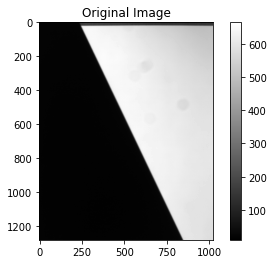

In [417]:
data_path = 'data\data\lab_3_2c_exp35_knife.npy'
data = np.load(data_path)

# Averaging image to remove noise
img = np.mean(data, axis=0)
img = np.transpose(img)

# Visualize original image
figure = plt.imshow(img, cmap='gray')
color = plt.colorbar(figure)
plt.title('Original Image')
plt.show()


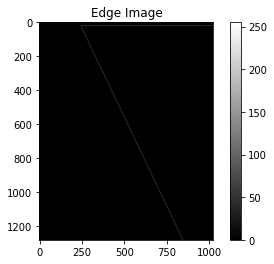

In [418]:
# Threshold & perform edge extraction
thresh = 300

bin_img = np.zeros_like(img)
bin_img = np.uint8(bin_img)
bin_img[img > thresh] = 255

# Perform edge detection
# check if gaussian blur is helpful
edge_img = cv2.Canny(bin_img, 80, 160)

# Visualize binary image
figure = plt.imshow(edge_img, cmap='gray')
color = plt.colorbar(figure)
plt.title('Edge Image')
plt.show()

In [419]:
lines = cv2.HoughLines(edge_img, 1, np.pi/180, 100, None, 0, 0)
line_angle = lines[1,0,1] #Radians
line_angle

2.687807

In [420]:
# Take transpose of image for vertical edge
img_t =  img #np.transpose(img)
edge_t = edge_img #np.transpose(edge_img)
line_angle = -line_angle

# Project image on one-dimensional trace
# Find the distance of each pixel on the 1D line
s_arr = []
val_arr = []
p = 5.3e-3 #Pixel dimension in mm (5.3e-3mm)
edge_val_thresh = 100
edge_coord = []
for y in range(50, edge_t.shape[0]): # Clipping initial 20 rows due to spurious edge
    count = 0
    edge_x = -1
    for x in range(edge_t.shape[1]):
        if edge_t[y, x] > edge_val_thresh:
            count = count + 1
            edge_coord.append(x)
            edge_x = x
        pixel_s = p*x*np.cos(line_angle) - p*y*np.sin(line_angle)
        val_arr.append(img_t[y,x])
        s_arr.append(pixel_s)
    if count > 1:
        print(str(count) + '-Mulitple edge points detected in row ' + str(y))

2-Mulitple edge points detected in row 165
2-Mulitple edge points detected in row 180
2-Mulitple edge points detected in row 312
2-Mulitple edge points detected in row 383
2-Mulitple edge points detected in row 433
2-Mulitple edge points detected in row 504
2-Mulitple edge points detected in row 776
2-Mulitple edge points detected in row 847
2-Mulitple edge points detected in row 893
2-Mulitple edge points detected in row 943
2-Mulitple edge points detected in row 1000
2-Mulitple edge points detected in row 1056
2-Mulitple edge points detected in row 1123
2-Mulitple edge points detected in row 1171
2-Mulitple edge points detected in row 1186
2-Mulitple edge points detected in row 1240
2-Mulitple edge points detected in row 1263


In [429]:
# Sort the pixel values based on distance
s_arr = np.array(s_arr)
val_arr = np.array(val_arr)
indx = s_arr.argsort()
s_arr = s_arr[indx]
val_arr = val_arr[indx]



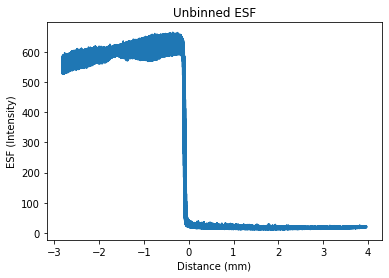

In [422]:
# # Clip tail to remove non-uniform values
s_arr = s_arr[40000:-1] 
val_arr = val_arr[40000:-1]
edge_offset = 1
plt.plot(s_arr + edge_offset, val_arr)
plt.title('Unbinned ESF')
plt.xlabel('Distance (mm)')
plt.ylabel('ESF (Intensity)')
plt.show()


In [423]:
# Bin according to distance
bin_size = 0.4*p

min_val = np.amin(s_arr)
max_val = np.amax(s_arr)
bins = np.arange(min_val, max_val+bin_size, step=bin_size)
esf_indx = np.digitize(s_arr, bins)

esf_hist = np.zeros_like(bins)
for i in range(0, len(val_arr)):
    bin_idx = esf_indx[i]
    esf_hist[bin_idx] = esf_hist[bin_idx] + val_arr[i]

s_count = np.bincount(esf_indx)
# plt.plot(s_count)
# plt.show()

esf_hist = esf_hist/ (s_count)
# esf_hist = np.histogram(s_arr, bins)
# esf_hist = esf_hist[50:14000]
# bins=bins[50:14000]

# plt.plot(bins, esf_hist)
# plt.show()

# Smoothing the esf with a gaussian kernel
esf_hist = gaussian_filter1d(esf_hist, 8)


C:\Users\mayan\AppData\Local\Temp\ipykernel_14168\2708493119.py:18: RuntimeWarning: invalid value encountered in true_divide
  esf_hist = esf_hist/ (s_count)


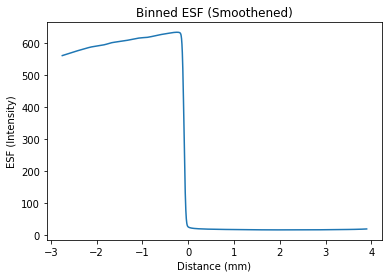

In [424]:

plt.plot(bins + edge_offset, esf_hist)
plt.title('Binned ESF (Smoothened)')
plt.xlabel('Distance (mm)')
plt.ylabel('ESF (Intensity)')
plt.show()

In [425]:
# plt.plot(edge_t[327, :])
# plt.show()
# print(indx)

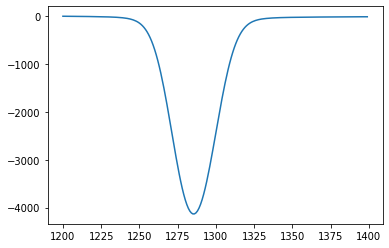

In [426]:
lsf = np.ediff1d(esf_hist) /(2*bin_size)

# # lsf = lsf[4000:8000]
clip_range = range(1200, 1400)
plt.plot(clip_range,lsf[clip_range])
# plt.plot(lsf)
plt.show()


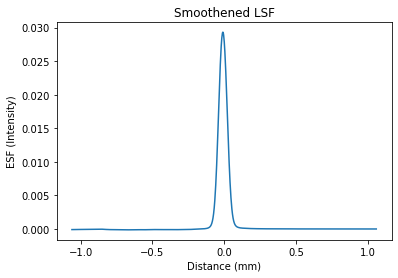

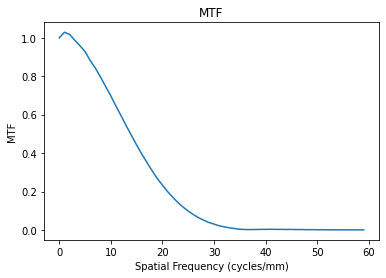

In [431]:
# Compute the LSF
lsf = np.ediff1d(esf_hist) /(2*bin_size)
peak = 1290
pix_range = np.arange(peak-500, peak+500)
lsf = (-1)*lsf[pix_range]
pix_range = (pix_range - peak)*bin_size
#smoothen using hanning window
# hann_filter = np.hanning(10)
# lsf_smooth = np.convolve(lsf, hann_filter, 'same')
lsf_smooth = lsf
lsf_smooth = lsf_smooth / np.sum(lsf_smooth)

# plt.plot(lsf)
# plt.show()
plt.plot(pix_range, lsf_smooth)
plt.title('Smoothened LSF')
plt.xlabel('Distance (mm)')
plt.ylabel('ESF (Intensity)')
plt.show()

mtf = np.fft.fftshift(np.fft.fft(lsf_smooth))
mtf_mag = np.abs(mtf)
# plt.plot(mtf_mag[500 : 550])
# plt.show()
clip_range = range(500,560)
#freq = np.arange(0, len(clip_range)) * (1/bin_size)
plt.plot(mtf_mag[clip_range])
plt.title('MTF')
plt.ylabel('MTF')
plt.xlabel('Spatial Frequency (cycles/mm)')
plt.show()

In [428]:
20/bin_size

4/p
# freq.shape
# mtf.shape

754.7169811320755